In [28]:
from functools import wraps

from vis.data.utils import DATADIR as datadir
from vis.code.analysis.decorators import pickle_data

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:99% !important; }</style>"))
import pandas as pd
import pickle

from plotly.offline import plot, iplot, init_notebook_mode
from plotly.subplots import make_subplots

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

init_notebook_mode(connected=True)
import plotly.graph_objects as go

import plotly.io as pio
# comment this out for html
pio.renderers.default = "png"

current_data_dir = '1585510246'
datapath = datadir.joinpath('analysis').joinpath('kmeans').joinpath(current_data_dir)
n_clusters = [3, 8, 16, 32, 64, 128, 256, 512, 1024]

In [29]:
# full data is 16 million colors, this is too many to run some analysis software so we're going to 
# take a small sample and just give it a sniff test that's representative
pop_file = "16m_rgb.pkl"
sample_file = 'frac_0_008_16m_rgb.pkl'
file_format = 'n_cluster_{}_kmeans.pkl'
df16 = pd.read_pickle(datapath.parent.parent.parent.joinpath(pop_file))
df_frac = pd.read_pickle(datapath.joinpath(sample_file))

In [30]:
# just see what the distribution of mean values are between the full set and the sample
# you'd expect to see something very normal given the nature of this data
# set reduced from 16 mil -> 134,218
population_mean = df16[['red', 'green', 'blue']].mean(axis=1)
sample_mean = df_frac[['red', 'green', 'blue']].mean(axis=1)

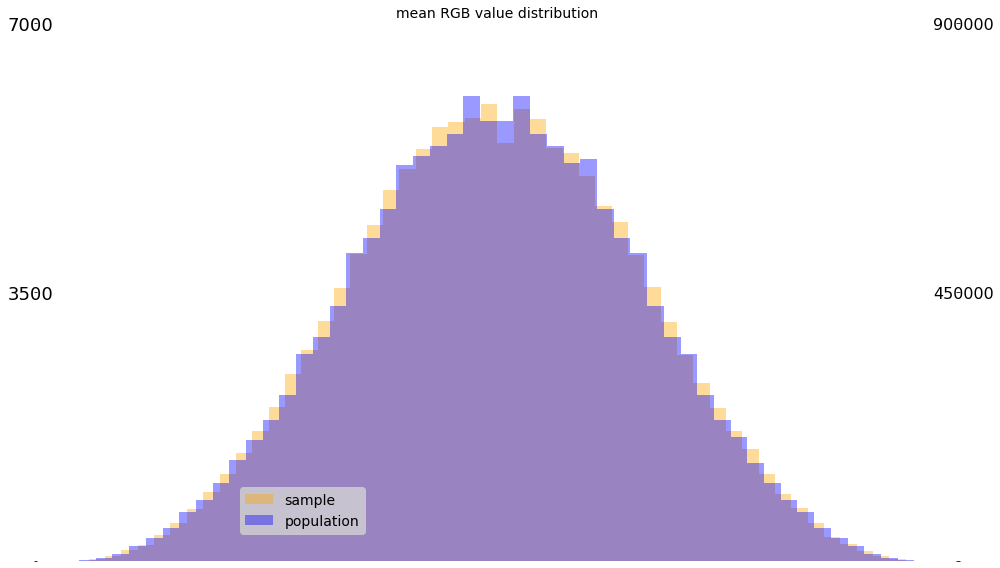

In [31]:
# plots share an x but have different y scales.
# use matplotlibs ax.twinx() method the axes will apply a left and a right y axis and scale to the size of the image(Im guessing)
# an important job of a good visualization package is to handle these things themselves.
# this is purely a feature of human vision to notice stark contrasts whereas here 
# Im more interested in the shape than the scale
fig, ax = plt.subplots(figsize=(14,8), edgecolor='blue', facecolor='white')
ax.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)

sns.distplot(sample_mean, ax=ax, kde=False, label='sample', color='orange')
ax.set_frame_on(False)
ax.set_alpha(0.5)
ax.set_yticks([0, 3500, 7000])
ax.set_facecolor('white')
ax.set_yticklabels(['', '3500', '7000'], dict(rotation=0, fontsize=18, color='black', ha='center'))

ax2 = ax.twinx()
sns.distplot(population_mean, ax=ax2, kde=False, label='population', color='blue')
ax2.set_frame_on(False)
ax.set_alpha(0.5)
ax2.set_yticks([0, 450000, 900000])
ax2.set_facecolor('white')

ax2.set_yticklabels(['', '450000', '900000'], dict(rotation=0, fontsize=16, color='black', ha='center'))
# ax.grid(color='black', clip_on=True)

# so freaking fiddly
fig.legend(bbox_to_anchor=[0.3, 0.1], loc='center', fontsize=14, facecolor='lightgrey')
ax.set_title('mean RGB value distribution', fontsize=14, loc='center', color='black')
fig.tight_layout()


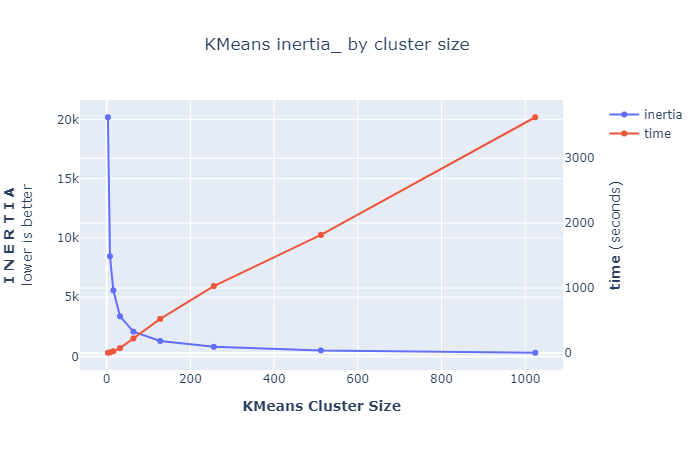

In [32]:
@pickle_data
def load_files_and_tags(tags, file_format, datapath, **kwargs):
    return map(list, zip(*kwargs.get('data')))

df = pd.read_csv(datapath.joinpath('kmeans_timing_data.csv'))
df['time_seconds'] = df.time.apply(lambda x: sum([int(x.split(':')[0]) * 60 * 60,
                                                  int(x.split(':')[1]) * 60,
                                                  int(x.split(':')[-1].split('.')[0])]))
x, y = load_files_and_tags(tags=n_clusters, file_format=file_format, datapath=datapath)
y = [i.inertia_ for i in y]

fig = make_subplots(specs=[[{"secondary_y": True}]])
fig.add_trace(go.Scatter(x=x, y=y, mode='markers+lines', name='inertia'))
fig.add_trace(go.Scatter(x=df['n'], y=df['time_seconds'], mode='markers+lines', name='time'), secondary_y=True)
fig.update_layout(title=dict(text='KMeans inertia_ by cluster size', xref='paper', x=0.5), 
                  yaxis=dict(title=dict(text='<b>I\tN\tE\tR\tT\tI\tA</b><br>lower is better</br>', font_size=14)),
                  xaxis=dict(title=dict(text='<b>KMeans Cluster Size</b>', font=dict(size=14))),
                  autosize=True)
fig.update_yaxes(title=dict(text="<b>time</b> (seconds)", font_size=14), secondary_y=True)
fig.show()